## EXERCISE 0

Download and extract the Python version of the CIFAR dataset from the CIFAR website.  
The dataset is structured as follows:

- **5 training batches** of 10,000 images each (50,000 images total)  
- **1 test batch** of 10,000 images  

Each batch file contains a **dictionary** with the following elements:

- **`data`** – a 10,000 × 3,072 NumPy array of `uint8`.  
  Each row represents a 32×32 color image:  
  - The first 1,024 entries are the red channel,  
  - The next 1,024 entries are the green channel,  
  - The final 1,024 entries are the blue channel.  
  Images are stored in **row-major order**, i.e., the first 32 entries correspond to the red values of the first row of the image.

- **`labels`** – a list of 10,000 integers in the range 0–9.  
  The number at index `i` indicates the label of the `i`th image in `data`.

The dataset also contains another file called **`batches.meta`**, which is a Python dictionary with the following entry:

- **`label_names`** – a 10-element list giving meaningful names to the numeric labels in the `labels` array described above.  
  For example:  
  ```python
  label_names[0] == "airplane"
  label_names[1] == "automobile"
  # etc.


## EXERCISE 1
Create a Dataset class to read the data. When initialized, this class should
take as arguments the path to the data, the transformation to be applied to each
image and if the dataset is train or test. If train you should load all
the 5 batches that composed the whole CIFAR training set. [2.0 pts]

The resulting class, `CIFAR10Dataset`, was designed to integrate seamlessly with the PyTorch framework, allowing full use of PyTorch tools for subsequent data processing and augmentation. 

In [70]:
import os
import pickle
import time
import json
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import (roc_auc_score, roc_curve, auc,
                             confusion_matrix, classification_report, accuracy_score)
from sklearn.preprocessing import label_binarize


class CIFAR10Dataset(Dataset):
    """
    CIFAR-10 dataset class compatible with PyTorch.

    Parameters
    ----------
    path : str
        Path to the CIFAR-10 batch files.
    data_type : str, default='train'
        Type of dataset to load. Must be 'train' or 'test'.
    transform : callable, optional
        A function/transform to apply to each image.

    Methods
    -------
    __len__()
        Returns the number of samples in the dataset.
    __getitem__(idx)
        Returns the image and label at the given index, applying the transform if specified.
    visualize(img, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        Display a single image (tensor or NumPy array), un-normalizing if needed.
    """
    def __init__(self, path, data_type='train', transform=None):

        self.path = path
        self.transform = transform

        # Load training data
        if data_type == 'train':
            data_list = []
            labels_list = []
            #Iterate for each of the 5 training batches
            for i_batch in range(1, 6):
                file = os.path.join(path, f"data_batch_{i_batch}")
                with open(file, 'rb') as fo:
                    # Deserialize binary batch files
                    batch = pickle.load(fo, encoding='bytes')
                    # Reshape data to (num_images, channels, height, width)
                    imgs = np.reshape(batch[b'data'], (10000, 3, 32, 32))
                    data_list.append(imgs)
                    #Creates one single label list for training
                    labels_list.extend(batch[b'labels'])
            self.data = np.vstack(data_list)  # combines all batches of train in a 4D Numpy array (50000,3,32,32)
            self.labels = np.array(labels_list) # converts all labels of train in a 1D Numpy array (50000,)

        # Load test data
        elif data_type == 'test':
            file = os.path.join(path, "test_batch")
            with open(file, 'rb') as fo:
                # Deserialize binary batch file
                batch = pickle.load(fo, encoding='bytes')
                # Reshape images to (num_images, channels, height, width)
                self.data = np.reshape(batch[b'data'], (10000, 3, 32, 32))
                self.labels = np.array(batch[b'labels']) # converts all labels of test in a 1D Numpy array (50000,)
        else:
            raise ValueError("data_type must be 'train' or 'test'")

    # Return number of samples
    def __len__(self):
        return len(self.data)


    #Function overrides __getitem__ standard python method called when an object is indexed.
    #The function will now return one sample (image and label) by index when object is indexed.
    # Any specified transformation is applied on-the-fly for efficiency and to allow online augmentation.

    def __getitem__(self, idx):
        img = self.data[idx]       # single image in CHW format (3,32,32)
        label = self.labels[idx]   # corresponding label
        img = np.transpose(img, (1, 2, 0))  # convert to HWC format for transforms/visualization
        
        if self.transform:
            img = self.transform(img)    # apply optional transform;

        return img, label

    def visualize(self, img, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)):
        """
        Display a single image (tensor or NumPy array), denormalizing if needed.
        Works for:
        - NumPy arrays HWC
        - Torch tensors CHW
        """
        if isinstance(img, torch.Tensor):
            npimg = img.numpy()  # Convert to NumPy
            # Check if tensor is CHW (3,H,W), then permute to HWC
            if npimg.shape[0] == 3 and len(npimg.shape) == 3:
                npimg = np.transpose(npimg, (1,2,0))  # CHW -> HWC
            # Denormalize
            mean_arr = np.array(mean).reshape(1,1,3)
            std_arr  = np.array(std).reshape(1,1,3)
            npimg = npimg * std_arr + mean_arr
            npimg = np.clip(npimg, 0, 1)
            plt.imshow(npimg)
        else:
            # NumPy array, assume already HWC
            plt.imshow(img)
        
        plt.axis('off')
        plt.show()




## Exercise 2
Build a CNN model to predict a class from the input image (you can use
the Conv2D module and one of the plenty pooling layers already implemented).
Which are the main hyperparameters you should set to build the main model?
Good practice is to build the model class as general as possible, and specify the
hyperparaemeters when the class is called. [2.0 pts]

The resulting class, `GeneralCNN`, was designed to integrate seamlessly with the PyTorch framework, allowing full use of PyTorch tools. Specifically, the class inherits from `nn.Module`, which enables automatic parameter management, supports custom forward passes, allows gradient computation via autograd, and ensures compatibility with optimizers and model saving/loading.


In [71]:
"""
MODULES in PyTorch are the fundamental building blocks of neural networks.
A module is any class that inherits from `nn.Module` and can encapsulate both
layers with learnable parameters (like `nn.Linear` or `nn.Conv2d` or personalized Moudles like GeneralCNN) 
and other submodules, forming a hierarchical structure.
Each module defines a `forward` method specifying how input data is transformed
into output, and all parameters registered within the module are automatically
tracked for gradient computation, optimization, and serialization.
"""

class GeneralCNN(nn.Module):
    """
    General CNN class compatible with PyTorch.

    Parameters
    ----------
    in_channels : int, default=3
        Number of input channels (e.g., 3 for RGB images).
    num_classes : int, default=10
        Number of output classes for classification.
    conv_layers : list of tuples, default=[(6,5), (16,5)]
        Each tuple defines a convolutional layer as (out_channels, kernel_size).
    pool_type : str, default='max'
        Type of pooling layer, either 'max' or 'avg'.
    pool_kernel : int, default=3
        Kernel size of the pooling layer.
    pool_stride : int, default=2
        Stride of the pooling layer.
    fc_layers : list of int, default=[120, 84]  
        Specifies the number of neurons in each fully connected layer 
        before the output layer and after the flattening.
    activation : str, default='relu'
        Activation function: 'relu', 'leaky_relu', or 'elu'.
    input_size : tuple, default=(32,32)
        Input image size as (height, width).

    Methods
    -------
    forward(x)
        Computes the forward pass of the network.
    """
    def __init__(self,
                 in_channels=3,
                 num_classes=10,
                 conv_layers=[(6, 5), (16, 5)],
                 pool_type='max',
                 pool_kernel=3,
                 pool_stride=2,
                 fc_layers=[120, 84],
                 activation='relu',
                 input_size=(32, 32)):
        
        #Call the init method of the nn.Module class
        super(GeneralCNN, self).__init__()

        # Select activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        elif activation == 'elu':
            self.activation = nn.ELU()
        else:
            raise ValueError("Unsupported activation")

        # Build convolutional layers
        self.layers = nn.ModuleList() #Create an object list of modules for the layers
        current_channels = in_channels
        for out_channels, kernel_size in conv_layers:
            conv = nn.Conv2d(current_channels, out_channels, kernel_size=kernel_size)
            self.layers.append(conv) #use the append of the nn.Modulelist class, to append the module
            current_channels = out_channels

        # Define pooling layer
        if pool_type == 'max':
            self.pool = nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride)
        elif pool_type == 'avg':
            self.pool = nn.AvgPool2d(kernel_size=pool_kernel, stride=pool_stride)
        else:
            raise ValueError("pool_type must be 'max' or 'avg'")

        self.fc_config = fc_layers
        self.num_classes = num_classes

        # Compute flattened size after conv + pool layers using a dummy input
        # Specifically, `torch.no_grad()` is used to avoid tracking gradients since no
        # backward pass or parameter update is needed during this computation.
        with torch.no_grad():
            # Creates a zero tensor of size [1, C, H, W] (1 image, C channels, H height, W width)
            # This dummy input is used to compute the flattened size after conv + pool layers;
            # the first value represents the batch size and can be any number selected
            dummy = torch.zeros(1, in_channels, input_size[0], input_size[1])
            x = dummy
            for conv in self.layers:
                x = conv(x)
                x = self.activation(x)
                if self.pool is not None:
                    x = self.pool(x)
            # This will flatten all dimensions except the batch and return the total number of features per image
            flattened_size = torch.flatten(x, start_dim=1).shape[1]

        # Build fully connected layers
        self.fc_layers = nn.ModuleList() #Create an object list of modules for the fully connected
        input_size_fc = flattened_size
        for units in self.fc_config:
            self.fc_layers.append(nn.Linear(input_size_fc, units))
            input_size_fc = units
        self.fc_layers.append(nn.Linear(input_size_fc, self.num_classes))

    def forward(self, x):
        """
        Forward pass through the network.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of shape (batch_size, in_channels, height, width).

        Returns
        -------
        torch.Tensor
            Output logits of shape (batch_size, num_classes). 
            Logits are the raw, unnormalized scores produced by the network for each class.
            They are not probabilities yet. To convert logits to probabilities, the torch.softmax() 
            function can be used.
        """
        for conv in self.layers:
            x = conv(x)
            x = self.activation(x)
            if self.pool is not None:
                x = self.pool(x)
        x = torch.flatten(x, 1)  # Flatten for fully connected layers
        for i, fc in enumerate(self.fc_layers):
            if i < len(self.fc_layers) - 1:
                x = self.activation(fc(x))
            else:
                x = fc(x)
        return x


In [72]:
"""
This class is responsible for managing the training, evaluation, and metrics computation of a model.
It exposes methods for:
  - training the model over multiple epochs,
  - evaluating it on train/test datasets,
  - computing metrics (accuracy, confusion matrices, ROC curves),
  - and saving results including plots and CSV metrics.
"""

class Experiment:
    """
    Handles training, evaluation, and metrics computation for a model.
    Configurations are passed via a single dictionary.
    """
    def __init__(self, config):
        # Required keys
        self.model = config["model"]
        self.exp_name = config.get("exp_name", "default_exp")
        self.data_path = config.get("data_path", "data")
        self.transform = config.get("transform", None)
        self.device = config.get("device", "cuda" if torch.cuda.is_available() else "cpu")
        self.class_names = config.get("class_names", [str(i) for i in range(10)])

        # Training parameters with defaults
        self.batch_size = config.get("batch_size", 64)
        self.num_epochs = config.get("num_epochs", 50)
        self.num_workers = config.get("num_workers", 0)
        self.criterion = config.get("criterion", torch.nn.CrossEntropyLoss())
        self.optimizer = config.get("optimizer", torch.optim.SGD(self.model.parameters(), lr=1e-3))

        # Datasets
        full_train_dataset = CIFAR10Dataset(path=self.data_path, data_type='train', transform=self.transform)
        self.test_dataset  = CIFAR10Dataset(path=self.data_path, data_type='test', transform=self.transform)

        # Split train dataset into training and validation
        val_size = int(0.2 * len(full_train_dataset))  # 20% for validation
        train_size = len(full_train_dataset) - val_size
        self.train_dataset, self.val_dataset = random_split(full_train_dataset, [train_size, val_size])

        # Data loaders
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        self.val_loader   = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
        self.test_loader  = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

        # Quick check
        img0, label0 = full_train_dataset[0]
        print(f"Sample visualization (exp={self.exp_name}) - Label: {label0}")
        full_train_dataset.visualize(img0, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))


    def train_epoch(self):
        """Train the model for a single epoch and return the average loss."""
        self.model.train()
        running_loss = 0.0

        for images, labels in self.train_loader:
            images = images.to(self.device, non_blocking=(self.num_workers > 0))
            labels = labels.to(self.device, non_blocking=(self.num_workers > 0))

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

        return running_loss / len(self.train_loader)

    def train(self):
        """Train the model for all epochs, track loss and epoch duration."""
        print(f"\n=== Starting training for experiment: {self.exp_name} ===")
        total_params = sum(p.numel() for p in self.model.parameters())
        opt_params = sum(p.numel() for g in self.optimizer.param_groups for p in g['params'])
        print(f"Total model params: {total_params}, Optimizer params: {opt_params}")
        assert total_params == opt_params, "Parameter count mismatch: optimizer may not include all model parameters"

        train_losses = []
        epoch_times = []

        total_start = time.perf_counter()

        for epoch in range(self.num_epochs):
            epoch_start = time.perf_counter()
            epoch_loss = self.train_epoch()
            epoch_end = time.perf_counter()
            epoch_duration = epoch_end - epoch_start

            train_losses.append(epoch_loss)
            epoch_times.append(epoch_duration)

            print(f"Epoch [{epoch+1}/{self.num_epochs}] - Avg Loss: {epoch_loss:.4f} - Time: {epoch_duration:.2f}s")

        total_end = time.perf_counter()
        total_training_time = total_end - total_start
        print(f"Total training time for {self.exp_name}: {total_training_time:.2f}s")

        self.train_losses = train_losses
        self.epoch_times = epoch_times
        return train_losses, epoch_times

    def eval_train(self):
        """Evaluate the model on the training set and return predicted probabilities and labels."""
        self.model.eval()
        all_probs, all_labels = [], []

        with torch.no_grad():
            for images, labels in self.val_loader:
                images = images.to(self.device)
                outputs = self.model(images)
                probs = torch.softmax(outputs, dim=1)
                all_probs.append(probs.cpu())
                all_labels.append(labels.cpu())

        self.all_probs_train = torch.cat(all_probs, dim=0).numpy()
        self.all_labels_train = torch.cat(all_labels, dim=0).numpy()
        return self.all_probs_train, self.all_labels_train

    def eval_test(self):
        """Evaluate the model on the test set and return predicted probabilities and labels."""
        self.model.eval()
        all_probs, all_labels = [], []

        with torch.no_grad():
            for images, labels in self.test_loader:
                images = images.to(self.device)
                outputs = self.model(images)
                probs = torch.softmax(outputs, dim=1)
                all_probs.append(probs.cpu())
                all_labels.append(labels.cpu())

        self.all_probs_test = torch.cat(all_probs, dim=0).numpy()
        self.all_labels_test = torch.cat(all_labels, dim=0).numpy()
        return self.all_probs_test, self.all_labels_test

    def compute_metrics(self, prob, labels):
        """Compute all relevant metrics given predicted probabilities and true labels."""
        pred = prob.argmax(axis=1)
        accuracy = accuracy_score(labels, pred)
        report = classification_report(labels, pred, digits=4)

        n_classes = len(self.class_names) if self.class_names is not None else 10
        all_labels_bin = label_binarize(labels, classes=np.arange(n_classes))

        roc_curves = {}
        try:
            for i in range(n_classes):
                fpr, tpr, _ = roc_curve(all_labels_bin[:, i], prob[:, i])
                auc_value = auc(fpr, tpr)
                roc_curves[i] = {'fpr': fpr, 'tpr': tpr, 'auc': auc_value}
            roc_auc_overall = roc_auc_score(all_labels_bin, prob, multi_class='ovr')
        except Exception:
            roc_curves = None
            roc_auc_overall = float('nan')

        cm = confusion_matrix(labels, pred)
        metrics_per_class, metrics_summary = metrics_from_confusion_matrix(cm, self.class_names)
        return accuracy, report, roc_auc_overall, roc_curves, cm, metrics_per_class, metrics_summary




        

#---------------------------
#     PLOTTING FUNCTIONS
#---------------------------
#Other functions used for plotting that is decoupled from the Experiment class logics

def save_metrics_csv(metrics_per_class, summary, csv_path):
    """
    Salva le metriche per classe e il summary in un CSV compatibile Excel.
    Usa ; come separatore e arrotonda decimali a 4 cifre.
    """

    fieldnames = ['class', 'TP', 'FP', 'FN', 'TN', 'precision', 'recall', 'specificity', 'f1', 'support']

    with open(csv_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=';')
        writer.writeheader()

        for cls, metrics in metrics_per_class.items():
            row = {'class': cls}
            for k in fieldnames[1:]:
                value = metrics[k]
                if isinstance(value, float):
                    value = round(value, 4)
                row[k] = value
            writer.writerow(row)

        # Riga vuota
        writer.writerow({})

        # Summary
        summary_row = {
            'class': 'SUMMARY',
            'precision': round(summary['macro_precision'], 4),
            'recall': round(summary['macro_recall'], 4),
            'f1': round(summary['macro_f1'], 4),
            'support': summary['total']
        }
        writer.writerow(summary_row)

    print(f"Saved metrics CSV to {csv_path}")


# Function to plot and save confusion matrix
def plot_cm(cm, title, path, class_names=None):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    thresh = cm.max() / 2. if cm.max() > 0 else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(int(cm[i, j]), 'd'),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")
    if class_names is not None:
        plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha='right')
        plt.yticks(np.arange(len(class_names)), class_names)
    plt.tight_layout()
    plt.savefig(path)
    plt.close()
    print(f"Saved confusion matrix to {path}")



# Function to plot and save the roc curves
def plot_roc_curves(roc_curves, class_names=None, title="ROC Curves", save_path=None):
    """
    Plot multi-class ROC curves from a dict of {class_idx: {'fpr':..., 'tpr':..., 'auc':...}}.
    """
    if roc_curves is None:
        print("No ROC curves to plot.")
        return

    plt.figure(figsize=(10, 8))
    
    for class_idx, data in roc_curves.items():
        fpr = data['fpr']
        tpr = data['tpr']
        auc_value = data['auc']
        name = class_names[class_idx] if class_names is not None else str(class_idx)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_value:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path)
        plt.close()
        print(f"Saved ROC curves to {save_path}")
    else:
        plt.show()


# Function to plot and save the loss function
def  plot_loss(exp_name,num_epochs,train_losses, plots_dir):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title(f'Training Loss over Epochs ({exp_name})')
    plt.grid(True)
    plt.tight_layout()

    # Save inside the experiment's plot directory
    loss_path = os.path.join(plots_dir, "loss.png")
    plt.savefig(loss_path)
    plt.close()

    print(f"Saved loss plot to {loss_path}")


#Visualize data description
def plot_data_description(full_train_dataset):

    # Extract data and labels
    X_train = torch.tensor(full_train_dataset.data).float() / 255.0  # Normalize to [0,1]
    y_train = torch.tensor(full_train_dataset.labels)  # <-- use labels, not targets

    # If channels are last (H,W,C), move to (N,C,H,W)
    if X_train.shape[1] != 3:  # your data is (N,3,32,32) already, so skip
        X_train = X_train.permute(0, 3, 1, 2)

    # Define class names manually (since your CIFAR10Dataset doesn't have .classes)
    classes = ['airplane', 'automobile', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))  # 1 row, 3 columns

    # Class distribution
    sns.countplot(x=[classes[i] for i in y_train.numpy()], ax=axes[0])
    axes[0].set_title("Distribution of CIFAR-10 Classes")
    axes[0].set_xlabel("Class Name")
    axes[0].set_ylabel("Count")
    axes[0].tick_params(axis='x', rotation=45)

    # Channel-wise correlations
    X_train_arr = X_train.view(-1, 3, 32*32).numpy()
    corr_matrix = np.corrcoef(X_train_arr.reshape(-1, 3).T)
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",
                xticklabels=["R","G","B"], yticklabels=["R","G","B"], ax=axes[1])
    axes[1].set_title("RGB Channel Correlation")

    # Pixel intensity distribution
    axes[2].hist(X_train.flatten().numpy(), bins=50, color='gray')
    axes[2].set_title("Pixel Intensity Distribution")
    axes[2].set_xlabel("Pixel Value")
    axes[2].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()



# ----------------------------
# Helper: compute per-class metrics from confusion matrix (one-vs-all)
# This follows the approach this requested article:
# https://towardsdatascience.com/multi-class-classification-extracting-performance-metrics-from-the-confusion-matrix-b379b427a872/
# ----------------------------
def metrics_from_confusion_matrix(cm, class_names=None):
    """
    Given a square confusion matrix cm (actual rows, predicted cols),
    compute per-class TP, FP, FN, TN and derived metrics:
      precision, recall (sensitivity), specificity, f1, support

    Returns:
      metrics_per_class: dict[class_name or index] -> dict of metrics
      summary: dict with macro-averages and overall accuracy
    """
    cm = np.array(cm, dtype=np.int64)
    n_classes = cm.shape[0]
    total = cm.sum()
    diag = np.diag(cm)
    metrics_per_class = {}
    eps = 1e-12

    for i in range(n_classes):
        TP = int(cm[i, i])
        FP = int(cm[:, i].sum() - TP)
        FN = int(cm[i, :].sum() - TP)
        TN = int(total - TP - FP - FN)

        precision = TP / (TP + FP + eps)
        recall = TP / (TP + FN + eps)  # sensitivity
        specificity = TN / (TN + FP + eps)
        f1 = 2 * precision * recall / (precision + recall + eps)
        support = int(cm[i, :].sum())

        name = class_names[i] if class_names is not None else str(i)
        metrics_per_class[name] = {
            'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN,
            'precision': precision, 'recall': recall,
            'specificity': specificity, 'f1': f1, 'support': support
        }

    # Overall metrics
    accuracy = diag.sum() / (total + eps)
    # macro averages
    macro_precision = np.mean([m['precision'] for m in metrics_per_class.values()])
    macro_recall = np.mean([m['recall'] for m in metrics_per_class.values()])
    macro_f1 = np.mean([m['f1'] for m in metrics_per_class.values()])

    summary = {
        'accuracy': accuracy,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'total': int(total)
    }

    return metrics_per_class, summary

Device: cpu


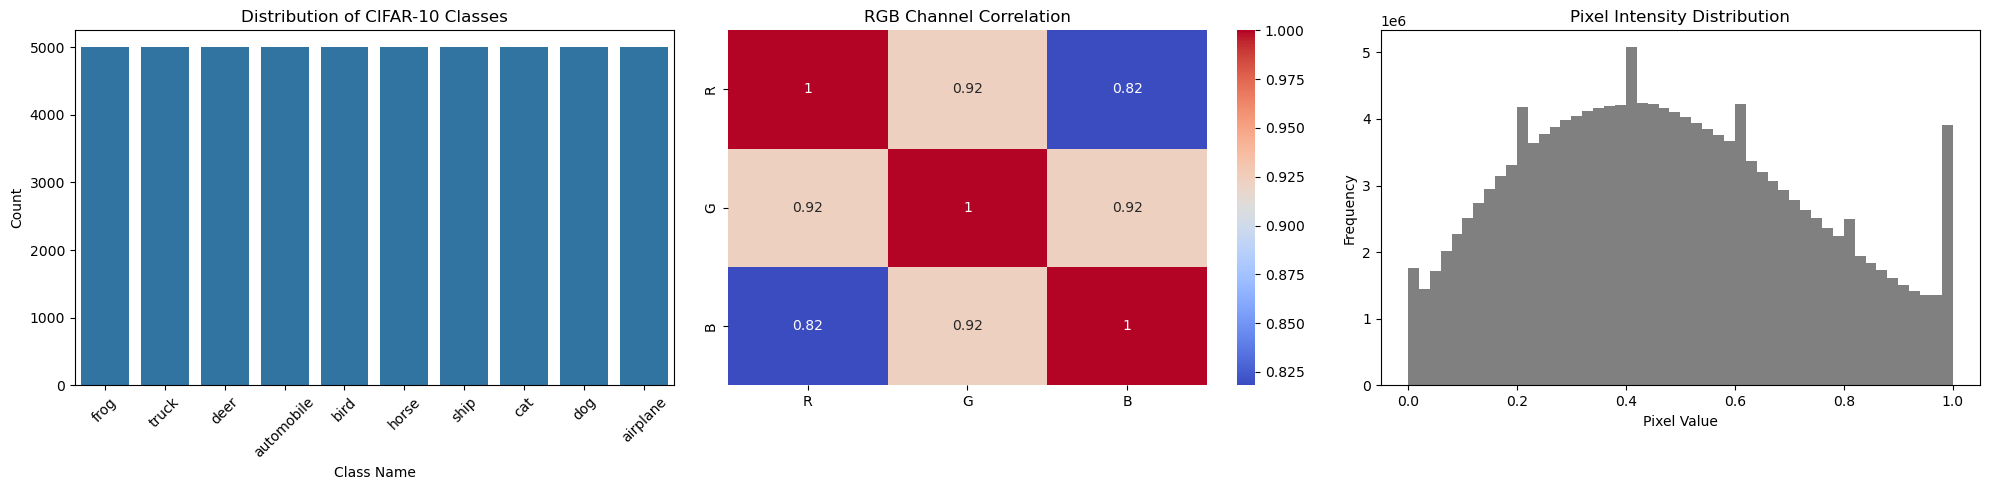


=== Running experiment: final_model ===
Sample visualization (exp=final_model) - Label: 6


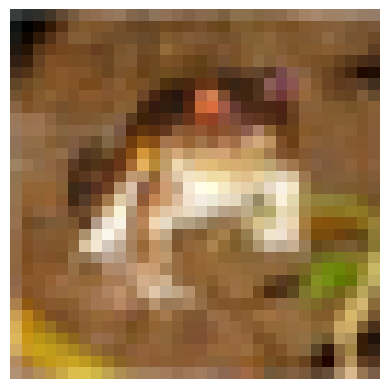


=== Starting training for experiment: final_model ===
Total model params: 44726, Optimizer params: 44726
Epoch [1/50] - Avg Loss: 2.2183 - Time: 7.52s
Epoch [2/50] - Avg Loss: 1.8126 - Time: 8.68s
Epoch [3/50] - Avg Loss: 1.6182 - Time: 7.48s
Epoch [4/50] - Avg Loss: 1.5141 - Time: 7.25s
Epoch [5/50] - Avg Loss: 1.4340 - Time: 7.23s
Epoch [6/50] - Avg Loss: 1.3583 - Time: 7.13s
Epoch [7/50] - Avg Loss: 1.2941 - Time: 7.18s
Epoch [8/50] - Avg Loss: 1.2463 - Time: 7.14s
Epoch [9/50] - Avg Loss: 1.2047 - Time: 7.09s
Epoch [10/50] - Avg Loss: 1.1691 - Time: 7.16s
Epoch [11/50] - Avg Loss: 1.1318 - Time: 7.08s
Epoch [12/50] - Avg Loss: 1.1047 - Time: 7.11s
Epoch [13/50] - Avg Loss: 1.0750 - Time: 7.08s
Epoch [14/50] - Avg Loss: 1.0497 - Time: 7.16s
Epoch [15/50] - Avg Loss: 1.0192 - Time: 7.09s
Epoch [16/50] - Avg Loss: 0.9955 - Time: 7.08s
Epoch [17/50] - Avg Loss: 0.9741 - Time: 7.10s
Epoch [18/50] - Avg Loss: 0.9541 - Time: 7.01s
Epoch [19/50] - Avg Loss: 0.9352 - Time: 7.17s
Epoch [20/

In [73]:
#----------------
#     MAIN
#-----------------
if __name__ == "__main__":
    import torch, os
    import numpy as np
    from torchvision import transforms
    from torch import nn, optim

    # ----------------------------
    # Seeds and device
    # ----------------------------
    torch.manual_seed(42)
    np.random.seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # ----------------------------
    # Data paths and common parameters
    # ----------------------------
    data_path = "data"
    num_workers = 0

    # ----------------------------
    # Load class names
    # ----------------------------
    labels_name = ['airplane', 'automobile', 'bird', 'cat',
                   'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # ----------------------------
    # Experiment configurations
    # ----------------------------
    experiment_configs = [
        {
            "exp_name": "final_model",
            "transform": transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ]),
            "data_path": data_path,
            "batch_size": 32,
            "num_epochs": 50,
            "device": device,
            "num_workers": num_workers,
            "class_names": labels_name,
            "model": GeneralCNN(),
            "criterion": nn.CrossEntropyLoss(),
            "optimizer": optim.SGD,
            "optimizer_params": {"lr": 0.001, "momentum": 0.9}
        }
    ]

    results = []

    # ----------------------------
    # Load full training dataset for visualization
    # ----------------------------
    full_train_dataset = CIFAR10Dataset(path=data_path, data_type='train', transform=None)
    plot_data_description(full_train_dataset)

    # ----------------------------
    # Run experiments
    # ----------------------------
    for cfg in experiment_configs:
        print(f"\n=== Running experiment: {cfg['exp_name']} ===")

        # Definisci plots_dir
        plots_dir = os.path.join("plots", cfg['exp_name'])
        os.makedirs(plots_dir, exist_ok=True)

        # Instanzia optimizer con i parametri del modello
        cfg["optimizer"] = cfg["optimizer"](cfg["model"].parameters(), **cfg["optimizer_params"])

        # Instanzia Experiment
        ex = Experiment(cfg)

        # Train
        start_time = time.time()
        ex.train()
        end_time = time.time()
        total_cnn_training_time = end_time - start_time
        ex.total_training_time = total_cnn_training_time   # save inside Experiment for convenience
        plot_loss(ex.exp_name, ex.num_epochs, ex.train_losses, plots_dir)

        # Evaluate
        prob_train, labels_train = ex.eval_train()
        prob_test, labels_test = ex.eval_test()

        # Compute metrics
        acc_train, report_train, roc_auc_train, roc_curves_train, cm_train, metrics_train_per_class, metrics_train_summary = ex.compute_metrics(prob_train, labels_train)
        acc_test, report_test, roc_auc_test, roc_curves_test, cm_test, metrics_test_per_class, metrics_test_summary = ex.compute_metrics(prob_test, labels_test)

        # Plot ROC curves
        plot_roc_curves(roc_curves_train, class_names=ex.class_names,
                        title=f'Multi-class ROC Curves (Train) - {ex.exp_name}',
                        save_path=os.path.join(plots_dir, "roc_curves_train.png"))
        plot_roc_curves(roc_curves_test, class_names=ex.class_names,
                        title=f'Multi-class ROC Curves (Test) - {ex.exp_name}',
                        save_path=os.path.join(plots_dir, "roc_curves_test.png"))

        # Plot confusion matrices
        plot_cm(cm_train, title=f'Confusion Matrix (Train) - {ex.exp_name}',
                path=os.path.join(plots_dir, "confusion_train.png"), class_names=ex.class_names)
        plot_cm(cm_test, title=f'Confusion Matrix (Test) - {ex.exp_name}',
                path=os.path.join(plots_dir, "confusion_test.png"), class_names=ex.class_names)

        cm_train_norm = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
        cm_test_norm  = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

        # Diffence normalized between train and test
        cm_diff_norm = cm_train_norm - cm_test_norm

        plot_cm(cm_diff_norm, title=f'Normalized Confusion Matrix Difference (Train - Test) - {ex.exp_name}',
                path=os.path.join(plots_dir, "confusion_diff.png"), class_names=ex.class_names)


        # Save per-class metrics
        save_metrics_csv(metrics_train_per_class, metrics_train_summary, os.path.join(plots_dir, "metrics_train.csv"))
        save_metrics_csv(metrics_test_per_class, metrics_test_summary, os.path.join(plots_dir, "metrics_test.csv"))
        print(f"\nSaved metrics for {ex.exp_name}")


        # Print summaries
        print(f"\n--- Summary for {ex.exp_name} ---")
        print(f"Train accuracy: {acc_train:.4f}, Test accuracy: {acc_test:.4f}, Test ROC AUC: {roc_auc_test:.4f}")
        print(f"Total training time: {sum(ex.epoch_times):.2f}s, Epoch times: {[round(t,2) for t in ex.epoch_times]}")

        # Store results
        results.append({
            'exp_name': ex.exp_name,
            'train_losses': ex.train_losses,
            'epoch_times': ex.epoch_times,
            'total_time': total_cnn_training_time, 
            'accuracy_train': acc_train,
            'accuracy_test': acc_test,
            'report_train': report_train,
            'report_test': report_test,
            'roc_auc_test': roc_auc_test,
            'confusion_train': cm_train,
            'confusion_test': cm_test,
            'confusion_diff': cm_train - cm_test,
            'metrics_test_per_class': metrics_test_per_class,
            'metrics_train_per_class': metrics_train_per_class,
            'metrics_test_summary': metrics_test_summary,   
            'plots_dir': plots_dir
        })

    # ----------------------------
    # High-level comparison summary
    # ----------------------------
    summary_path = os.path.join("plots", "comparison_summary.txt")
    os.makedirs("plots", exist_ok=True)
    with open(summary_path, 'w') as f:
        f.write("Comparison of experiments\n\n")
        for r in results:
            f.write(f"{r['exp_name']} results:\n")
            f.write(f"  Train acc: {r['accuracy_train']:.4f}\n")
            f.write(f"  Test  acc: {r['accuracy_test']:.4f}\n")
            f.write(f"  Total training time: {r['total_time']:.2f}s\n\n")

    print(f"\nSaved comparison summary to {summary_path}")
    print("Done.")


## **Exercise 5**

Device: cpu
Train batches: 1563, Test batches: 313
MLP(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (act): ReLU()
)
Epoch 1/50 | Loss=1.9122 | Train Acc=0.3258 | Test Acc=0.4066 | Test F1=0.3919
Epoch 2/50 | Loss=1.6163 | Train Acc=0.4307 | Test Acc=0.4533 | Test F1=0.4477
Epoch 3/50 | Loss=1.5005 | Train Acc=0.4740 | Test Acc=0.4850 | Test F1=0.4761
Epoch 4/50 | Loss=1.4141 | Train Acc=0.5047 | Test Acc=0.5025 | Test F1=0.4942
Epoch 5/50 | Loss=1.3432 | Train Acc=0.5302 | Test Acc=0.5167 | Test F1=0.5118
Epoch 6/50 | Loss=1.2839 | Train Acc=0.5497 | Test Acc=0.5194 | Test F1=0.5144
Epoch 7/50 | Loss=1.2286 | Train Acc=0.5701 | Test Acc=0.5196 | Test F1=0.5148
Epoch 8/50 | Loss=1.1788 | Train Acc=0.5885 | Test Acc=0.5299 | Test F1=0.5228
Epoch 9/50 | Loss=1.1303 | Train Acc=0.6056 | Test Acc=0.5242 | Test F1=0.5203
Epoch 10/50 | Loss=1.0868 | T

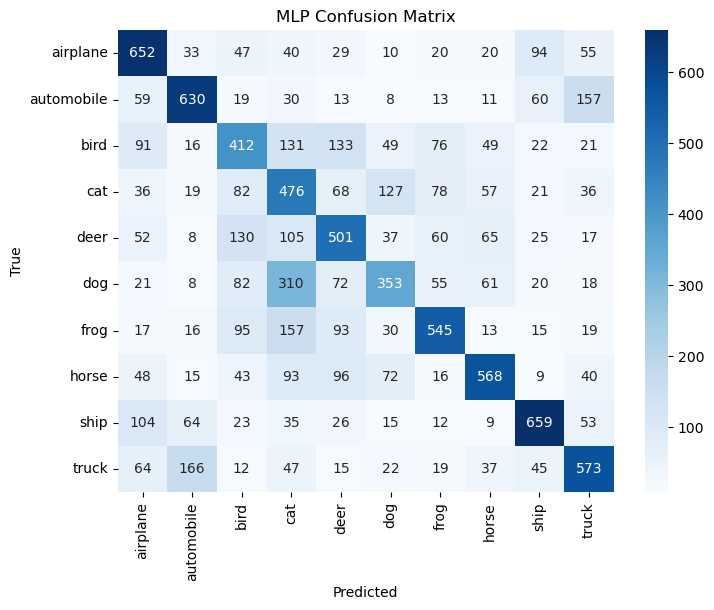

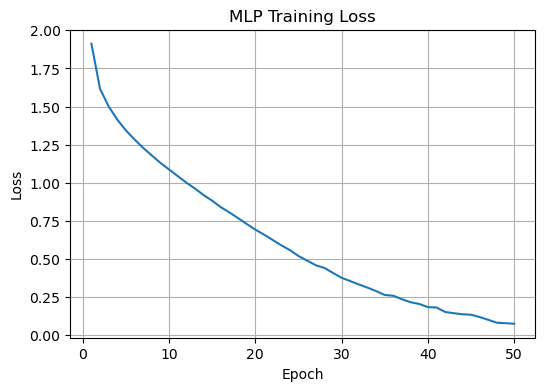

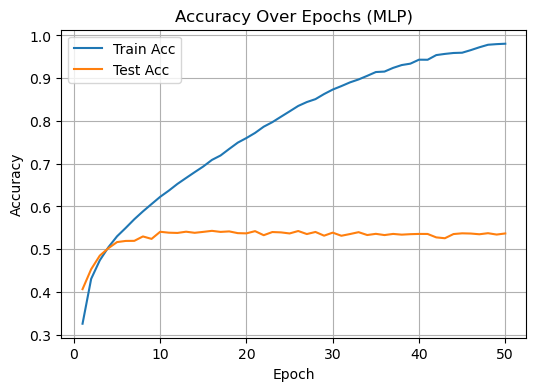

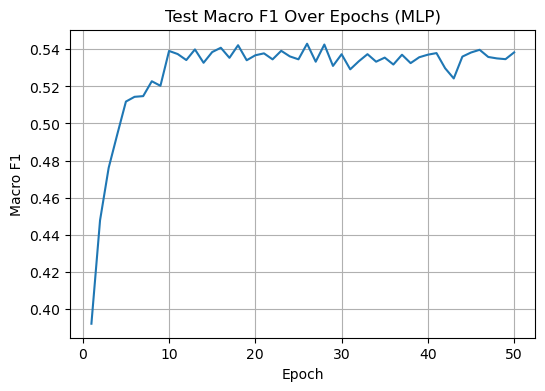

In [74]:
#!/usr/bin/env python3
"""
Improved MLP training script for CIFAR-10.

Key improvements:
- Uses DataLoader (batching, shuffling, num_workers) instead of iterating dataset directly.
- Flattens images on-the-fly inside the model (so training loop accepts CHW tensors).
- Moves tensors to device and uses correct dtypes.
- Computes metrics safely for sklearn (converts to numpy on CPU).
- Tries to reuse CIFAR10Dataset / loaders from an existing cnn pipeline module if available,
  otherwise falls back to torchvision.datasets.CIFAR10.
"""
import time
import importlib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns

# ----------------------------
# Try to reuse CIFAR10Dataset or loaders from an existing cnn_pipeline module
# Replace 'cnn_pipeline' with your CNN file/module name if needed.
# ----------------------------
CIFAR10Dataset = None
dl_train = None
dl_test = None
classes = None
data_path = "data"

try:
    cnn_mod = importlib.import_module('cnn_pipeline')  # change if your CNN module has a different name
    CIFAR10Dataset = getattr(cnn_mod, 'CIFAR10Dataset', None)
    dl_train = getattr(cnn_mod, 'train_loader', None)
    dl_test = getattr(cnn_mod, 'test_loader', None)
    classes = getattr(cnn_mod, 'labels_name', getattr(cnn_mod, 'class_names', None))
    data_path = getattr(cnn_mod, 'data_path', data_path)
    print("Imported dataset/loaders from cnn_pipeline.")
except Exception:
    # Not fatal; we'll build our own loaders below
    pass

# ----------------------------
# If loaders aren't provided, create them (same transform used by your CNN)
# ----------------------------
batch_size = 32
num_workers = 0

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

if dl_train is None or dl_test is None:
    if CIFAR10Dataset is not None:
        train_dataset = CIFAR10Dataset(path=data_path, data_type='train', transform=transform)
        test_dataset = CIFAR10Dataset(path=data_path, data_type='test', transform=transform)
    else:
        # fallback to torchvision CIFAR10 (will download if necessary)
        train_dataset = datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
        test_dataset  = datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
    dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=torch.cuda.is_available())
    dl_test  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=torch.cuda.is_available())
    classes = getattr(train_dataset, 'classes', classes if classes is not None else [str(i) for i in range(10)])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print(f"Train batches: {len(dl_train)}, Test batches: {len(dl_test)}")

# ----------------------------
# MLP model (flattens inside forward)
# ----------------------------
class MLP(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, output):
        super().__init__()
        # You may keep input_size for readability; model will flatten inputs automatically
        self.fc1 = nn.Linear(input_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, output)
        self.act = nn.ReLU()

    def forward(self, x):
        # flatten any input of shape (B, C, H, W) or (B, N)
        x = x.view(x.size(0), -1)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        return x

input_size = 3 * 32 * 32
mlp = MLP(input_size, 512, 256, 10).to(device)
print(mlp)

# ----------------------------
# Training setup
# ----------------------------
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp.parameters(), lr=1e-3, momentum=0.9)
epochs = 50

train_losses = []
train_accs = []
test_accs = []
test_f1s = []

start_time = time.time()

for epoch in range(1, epochs + 1):
    mlp.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for imgs, labels in dl_train:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).long()

        optimizer.zero_grad()
        logits = mlp(imgs)            # flattening happens inside the model
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

    avg_loss = running_loss / running_total
    train_acc = running_correct / running_total
    train_losses.append(avg_loss)
    train_accs.append(train_acc)

    # Evaluation on test set
    mlp.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in dl_test:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).long()
            logits = mlp(imgs)
            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    y_pred = torch.cat(all_preds)
    y_true = torch.cat(all_labels)

    test_acc = accuracy_score(y_true.numpy(), y_pred.numpy())
    test_f1  = f1_score(y_true.numpy(), y_pred.numpy(), average="macro")
    test_accs.append(test_acc)
    test_f1s.append(test_f1)

    print(f"Epoch {epoch}/{epochs} | Loss={avg_loss:.4f} | Train Acc={train_acc:.4f} | Test Acc={test_acc:.4f} | Test F1={test_f1:.4f}")

end_time = time.time()
total_mlp_training_time = end_time - start_time
print(f"Total MLP training time: {total_mlp_training_time:.2f} seconds")

# ----------------------------
# Final report and plots
# ----------------------------
if classes is None:
    classes = [str(i) for i in range(10)]

print("\n=== FINAL CLASSIFICATION REPORT (Test) ===")
print(classification_report(y_true.numpy(), y_pred.numpy(), target_names=classes))

cm = confusion_matrix(y_true.numpy(), y_pred.numpy())
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.title("MLP Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_accs, label="Train Acc")
plt.plot(range(1, epochs+1), test_accs, label="Test Acc")
plt.legend()
plt.title("Accuracy Over Epochs (MLP)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), test_f1s, label="Test Macro F1")
plt.title("Test Macro F1 Over Epochs (MLP)")
plt.xlabel("Epoch")
plt.ylabel("Macro F1")
plt.grid()
plt.show()

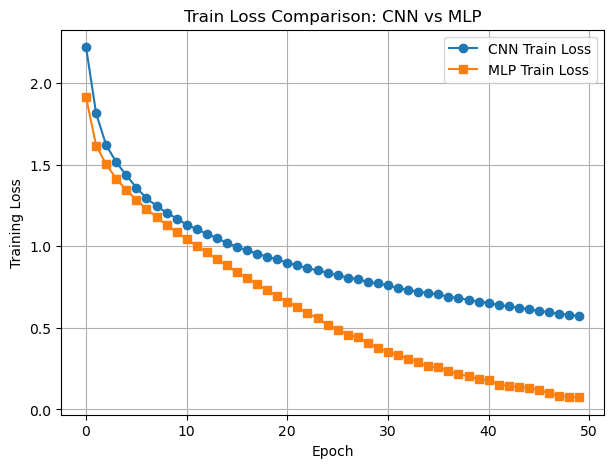

=== MODEL PERFORMANCE SUMMARY ===

Model      | Test Acc       | Train Time (s)
---------------------------------------------
CNN        | 0.6491         |   360.12
MLP        | 0.5369         |   329.63


In [90]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# -------------------------------
# 1. Assign CNN metrics
# -------------------------------
# Use your results dictionary directly
cnn_train_losses = results[0].get('train_losses', [])  # List of training loss per epoch
cnn_train_acc = results[0].get('accuracy_train', 0.0)
cnn_test_acc = results[0].get('accuracy_test', 0.0)

if 'metrics_test_summary' in results[0]:
    cnn_test_f1 = results[0]['metrics_test_summary'].get('f1_macro', 0.0)
else:
    cnn_test_f1 = 0.0

cnn_train_time = results[0].get('total_time', 0.0)
cnn_class_report = results[0].get('report_test', "No report available")

# -------------------------------
# 2. Assign MLP metrics
# -------------------------------
mlp_train_losses = train_losses  # List of training loss per epoch
mlp_train_acc = train_accs[-1]   # Last epoch train accuracy
mlp_test_acc = test_accs[-1]     # Last epoch test accuracy
mlp_test_f1 = test_f1s[-1]       # Last epoch macro F1

mlp_class_report = classification_report(y_true, y_pred, target_names=classes)

# -------------------------------
# 3. Plot Train Loss Comparison
# -------------------------------
plt.figure(figsize=(7,5))
plt.plot(cnn_train_losses, label="CNN Train Loss", marker='o')
plt.plot(mlp_train_losses, label="MLP Train Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Train Loss Comparison: CNN vs MLP")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# 4. Summary Table
# -------------------------------
print("=== MODEL PERFORMANCE SUMMARY ===\n")
print(f"{'Model':<10} | {'Test Acc':<10}     | {'Train Time (s)':<12}")
print("-"*45)
print(f"{'CNN':<10} | {cnn_test_acc:.4f}         |   {total_cnn_training_time:.2f}")
print(f"{'MLP':<10} | {mlp_test_acc:.4f}         |   {total_mlp_training_time:.2f}")
